# Advertising: Finding the target audience for the Ad
## _Data Science Project - [Kaggle](https://www.kaggle.com/fayomi/advertising)_
### Author: Sabareesh Mamidipaka


                          ====================================================

This project is divided in 5 sections:

1. Introduction

2. Exploring The Data

    2.1 The Data
    
3. Exploratory Data Analysis (EDA)

    3.1 Describing Features
    
        3.1.1 Sanity Check
    
    3.2 Descriptive Figures
    
        3.2.1 Distribution Plots
        
        3.2.2 Boxplots
        
        3.2.3 Cross-correlation Plot
        
        3.2.4 Distribution Plots With Respect To Our Target Feature
        
        3.2.5 Pair Plots With Respect To Our Target Feature
    
    3.3 Feature Engineering

        3.3.1 Skewed Features: Log Transform
        
        3.3.2 Removing Some Features
        
        3.3.3 Normalization Of Numerical Features
        
        3.3.4 Processing Categorical Feature: One Hot-Encoding

4. Model Selection

    4.1 Data Preparation: Training and Testing Sets

    4.2 Model Selection: Logistic Regression
    
        4.2.1 Logistic Regression
        
        4.2.2 Confusion Matrix, Precision, Recall, F1-Score

5. Actionable Recommendations

# 1. Introduction

The task is to predict who will most likely click on the ad. Let's consider that we are working for a marketing company. Firstly, we have to understand what constitutes a profit and a loss. 

Let's assume that you have a marketing campaign for which we spend **1000USD per potential customer**. For each **customer that we target** with our ad campaign **and** that **clicks on the ad**, we get an **overall profit of 100USD**. However, if we target a **customer that ends up not clicking** on the ad, we incur a **net loss of 1050USD**. Therefore we can conclude that for each **customer that was not targeted** by the campaign **and** who **clicks on the ad**, we get an **overall profit of 1100USD**. Unfortunately, we have no information about the advertized product; this information could have guided us through our understanding of the user behavior.


In [5]:
# Importing librairies
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer, fbeta_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from collections import Counter

%matplotlib inline 


# 2. Exploring the Data

## 2.1 The data:

There is one data set provided with this problem.

_**We will perform the exploratory data analysis on the whole set, before separating it into a training ans test sets later before performing machine learning.**_

In [6]:
# Loading the data
advertising = pd.read_csv("advertising_dataset.csv")
advertising.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 0:53,0.0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 1:39,0.0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35,0.0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 2:31,0.0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 3:36,0.0


Let's look at the main characteristics of our dataset, such as the number of observations, the type of variables, the summary statistics for each variables, the number of missing data, etc.

In [6]:
advertising.info()
print()
print(advertising.isnull().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1018 non-null   float64
 1   Age                       1018 non-null   int64  
 2   Area Income               1018 non-null   float64
 3   Daily Internet Usage      1018 non-null   float64
 4   Ad Topic Line             1018 non-null   object 
 5   City                      1018 non-null   object 
 6   Male                      1018 non-null   int64  
 7   Country                   1018 non-null   object 
 8   Timestamp                 1018 non-null   object 
 9   Clicked on Ad             1014 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 79.7+ KB

Daily Time Spent on Site    False
Age                         False
Area Income                 False
Daily Internet Usage        False
Ad Topic Line               False

Convert the 'Timestamp' feature to datetime variable for convenient usage if required.

In [7]:
advertising["Timestamp"] = pd.to_datetime(advertising["Timestamp"])

In [8]:
# Defining categorical, numerical, and datetime variables
categorical_vars = ["Ad Topic Line", "City", "Country"]
numerical_vars = ["Daily Time Spent on Site", "Area Income", "Daily Internet Usage", "Male", "log_age"]
datetime_vars = "Timestamp"
target = "Clicked on Ad"

In [9]:
# We have missing values in the target feature. It's useless having those rows as we cannot impute these values
advertising = advertising.dropna(axis=0)

# Removing the duplicated rows from the dataset if present
advertising = advertising.drop_duplicates()

---------

# 3. Exploratory Data Analysis (EDA)
## 3.1 Describing The Features

In [10]:
# Look at the distribution of the target feature to check for any imbalance in the dataset
click_rate = advertising["Clicked on Ad"].value_counts() / advertising.shape[0]
click_rate

Clicked on Ad
1.0    0.502483
0.0    0.497517
Name: count, dtype: float64

### Sanity check

Make sure that the feature values make sense.

In [11]:
# Extract Descriptive Statistics for int and float datatypes
advertising.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad
count,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1007,1007.000000
mean,64.952403,36.958292,54899.398868,179.386514,0.482622,2016-04-10 12:51:42.303872768,0.502483
min,32.600000,-25.000000,13996.500000,23.640000,0.000000,2016-01-01 02:52:00,0.000000
25%,51.270000,29.000000,46899.780000,138.490000,0.000000,2016-02-18 13:20:00,0.000000
50%,68.100000,35.000000,56984.090000,182.200000,0.000000,2016-04-07 18:52:00,1.000000
75%,78.535000,42.000000,65350.775000,218.550000,1.000000,2016-05-31 07:43:30,1.000000
max,91.430000,999.000000,79484.800000,269.960000,1.000000,2016-07-24 00:22:00,1.000000
std,15.850441,31.729539,13458.555374,44.548765,0.499946,NaN,0.500242


Mean and median are similar for most of the features. So, looks like the features are not very skewed. But we can see that the max and min of 'Age' have unrealistic values. So, there are outliers we need to take care of!

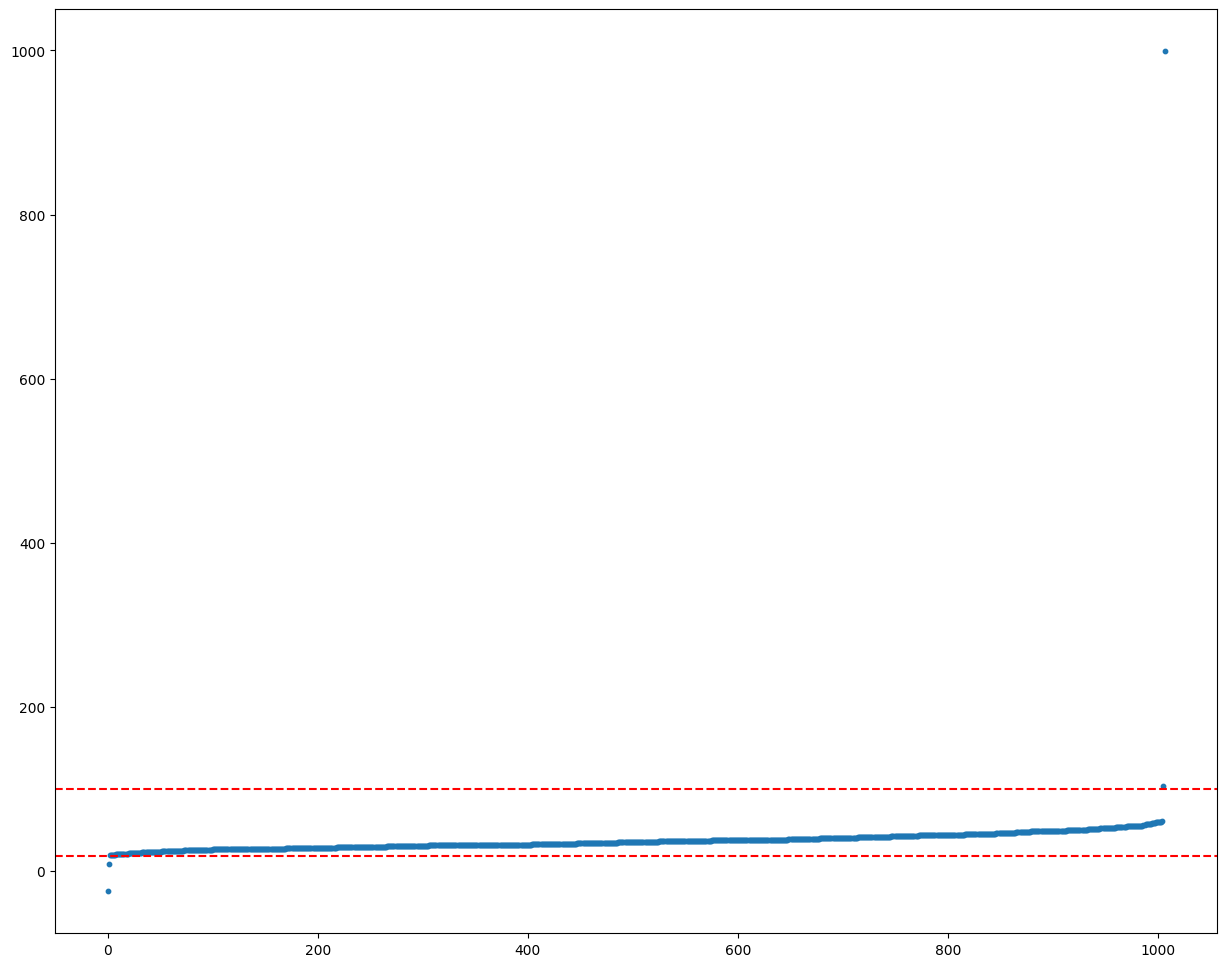

In [12]:
# Plotting sorted age against their index
sorted_age = sorted(advertising['Age'])
y = sorted_age

plt.figure(figsize=(15,12))
plt.scatter(range(len(sorted_age)), y, s=10)

# We will see how many people are beyond the cutoff of 18 and 100 years
plt.axhline(y=18, linestyle='--', color='r')
plt.axhline(y=100, linestyle='--', color='r')

In [13]:
# Removing the extreme age values
advertising = advertising[(advertising['Age'] >= 18) & (advertising['Age'] < 100)]


In [14]:
advertising.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:00,0.0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:00,0.0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:00,0.0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:00,0.0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:00,0.0


One more thing to check is if the 'Daily TIme Spend on Site' is actually smaller or equal to the 'Daily Internet Usage'.

If not, then the observation is possibly faulty.

In [15]:
advertising[(advertising['Daily Internet Usage'] < advertising['Daily Time Spent on Site'])]

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
114,46.13,46,37838.72,23.64,Horizontal hybrid challenge,New Rachel,1,Guyana,2016-01-09 05:44:00,1.0
331,86.78,30,54952.42,70.13,Fundamental zero tolerance solution,New Steve,1,United States of America,2016-02-18 23:08:00,0.0
404,66.99,47,27262.51,24.44,Operative actuating installation,Lopezberg,1,Tanzania,2016-06-15 11:56:00,1.0


We have some observations like that. So, let's remove these values from the dataset.

In [16]:
# Removing the rows which don't make sense. 

advertising= advertising[(advertising['Daily Internet Usage'] > advertising['Daily Time Spent on Site'])]

## 3.2 Descriptive Figures
### 3.2.1 Distribution Plots

In [19]:
# Functions that we will use later on
def data_info(data):
    return data.info()

def creating_boxplots(size, target, features, data):
    plt.figure(figsize=size)
    for i in range(len(numerical_vars)):
        plt.subplot(5, 3, i+1)
        sns.boxplot(x=target, y=features[i], data=data )
        
def creating_distplot(size, data, features):
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(5, 3, i+1)
        sns.distplot(data[features[i]])
        
# def crossCorrelation(data):
#     corr = data.corr()
#     plt.figure(figsize=(10,6))
#     sns.heatmap(corr, 
#           xticklabels=corr.columns.values,
#           yticklabels=corr.columns.values)
#     print(corr)

def crossCorrelation(data):
    # Select only numeric columns
    numeric_data = data.select_dtypes(include=['float64', 'int64'])
    
    # Compute correlation
    corr = numeric_data.corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)
    plt.title('Correlation Matrix')
    plt.show()



/tmp/ipykernel_32821/1039428173.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[features[i]])
/home/abhi/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/abhi/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel

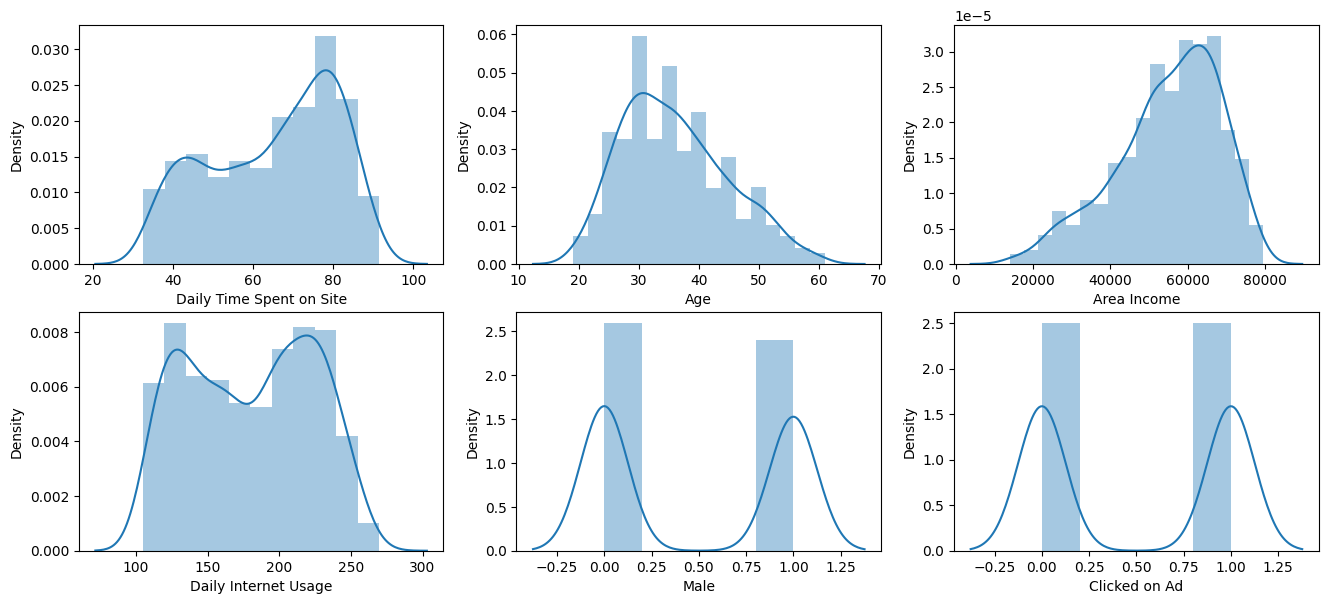

In [20]:
# Select the variables for which we can do a distribution plot (integer and float)
num_vars = advertising.select_dtypes(include=['int64', 'float64']).columns

# Creating distribution plots
creating_distplot((16,18), advertising, num_vars)

Interestingly, 'Daily Time Spent on Site' and 'Daily Internet Usage' seem to be bimodal with a possibility of two different groups present there. 'Age' and 'Area Income' are slighly skewed and may cause a bias depending on the model we choose later.  

### 3.2.2 Boxplots

/home/abhi/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/abhi/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/abhi/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/abhi/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.

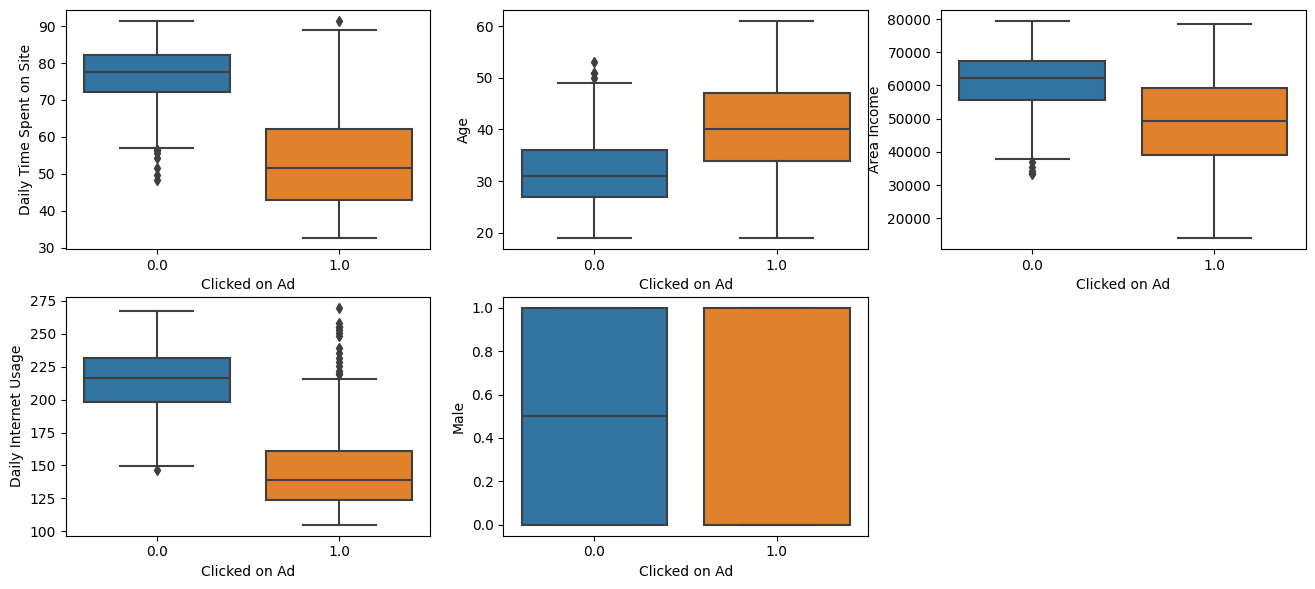

In [21]:
# Generating boxplots with respect to our target feature
creating_boxplots((16,18), target, num_vars, advertising)

There is a marked difference between the 'Daily Time Spent on Site' and 'Daily Internet Usage' for the groups who clicked and not clicked. The plots also suggest that older and lower income households seems to be more attracted by the ad. Another interesting and slightly unconventional trend is that the people who spent less time on the site are most likely to click on the advertisement.

In [22]:
# Since the boxplot for the dependence of 'Male' on clicked on target' is not clear, we will make a countplot 
# to get a clearer picture.

# plt.figure(figsize=(10,5))
# order = ['Male','Female']
# for i in range(2):
#     plt.subplot(1, 2, i+1)
#     ax = sns.countplot(advertising[advertising['Male']==i]['Clicked on Ad'])
#     ax.set_title(order[i])
#     plt.tight_layout()

# plt.suptitle('Distribution of clicks on target based on sex.', y=1.02, fontsize='xx-large')


# import matplotlib.pyplot as plt
# import seaborn as sns

# # Check if 'Male' column is present in the data
# if 'Male' in advertising:
#     plt.figure(figsize=(10,5))
    
#     male_values = advertising['Male'].unique()  # Get unique values of 'Male' column
    
#     # Check if there is data available for both male values
#     if len(male_values) == 2 and 0 in male_values and 1 in male_values:
#         for i, male_data in enumerate(male_values):
#             # If male data is 0, plot female (where 'Male' is 1)
#             # If male data is 1, plot male (where 'Male' is 0)
#             plt.subplot(1, 2, i+1)
#             if male_data == 0:
#                 gender_label = 'Female'
#                 plot_data = advertising[advertising['Male']==1]['Clicked on Ad']
#             else:
#                 gender_label = 'Male'
#                 plot_data = advertising[advertising['Male']==0]['Clicked on Ad']
            
#             ax = sns.countplot(plot_data)
#             ax.set_title(gender_label)
#             plt.tight_layout()

#         plt.suptitle('Distribution of clicks on target based on sex.', y=1.02, fontsize='xx-large')
#         plt.show()
#     else:
#         print("Data for both 'Male' categories is not available.")
# else:
#     print("Data for 'Male' category is not available.")




There seems to be no relation on the gender of the audience based on the plots above.

### 3.2.3 Cross-correlation Plot

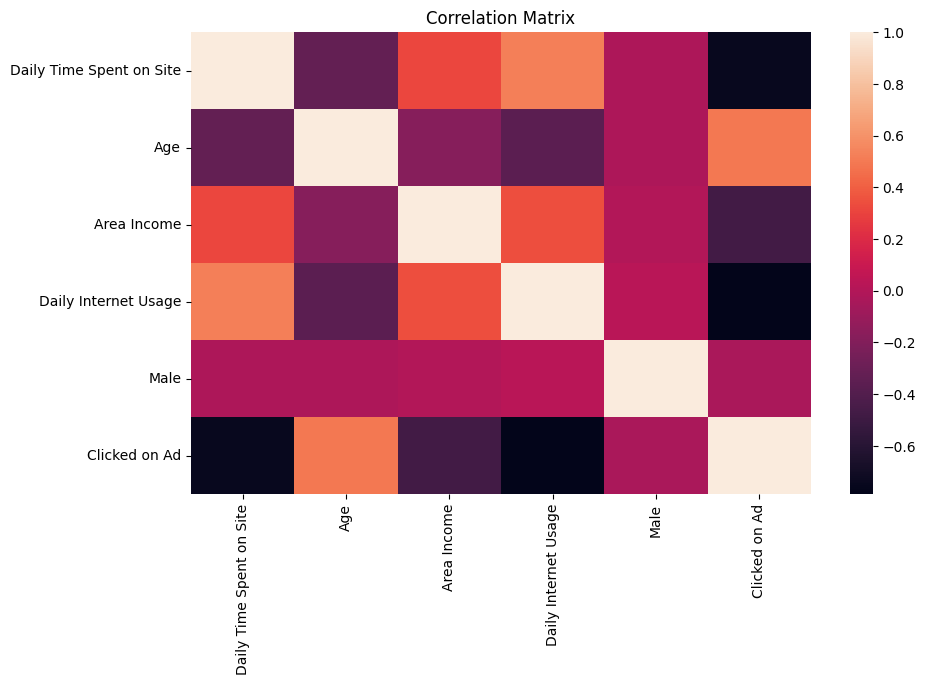

In [23]:
# Cross-correlation between the different features
crossCorrelation(advertising)

Apart from the 'sex' feature, all other features seem to be correlated with the 'clicked on Ad' target feature. We can defintely consider dropping this feature as there 

### 3.2.4 Distribution Plots With Respect To Our Target Feature

/tmp/ipykernel_32821/657560822.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(advertising[feature][click_yes], label=labels[0], color="b")
/home/abhi/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/abhi/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('m

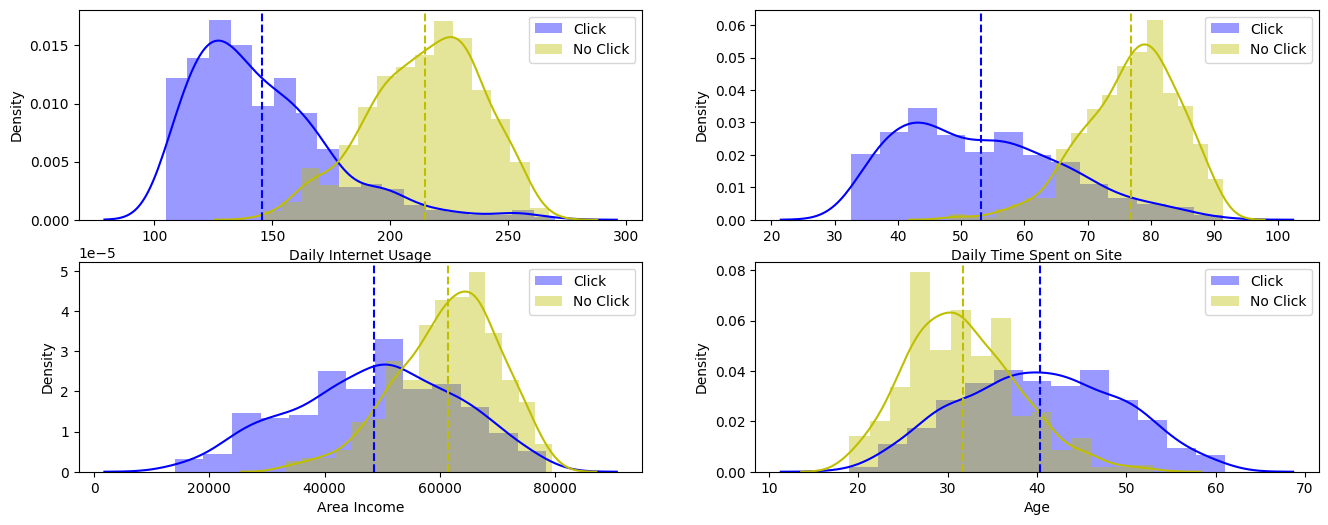

In [24]:
# Subsetting by clicks
click_yes = advertising["Clicked on Ad"] == 1
click_no = advertising["Clicked on Ad"] == 0

# Creating the plots
features = ["Daily Internet Usage", "Daily Time Spent on Site", "Area Income", "Age"]
labels = ["Click", "No Click"]

def creating_plots(features, labels):
    plt.figure(figsize=(16,6))
    for feature in features:
        plt.subplot(2, 2, features.index(feature)+1)
        sns.distplot(advertising[feature][click_yes], label=labels[0], color="b")
        sns.distplot(advertising[feature][click_no], label=labels[1], color="y")
        plt.axvline(advertising[feature][click_yes].mean(), linestyle = '--', color="b")
        plt.axvline(advertising[feature][click_no].mean(), linestyle = '--', color="y")
        plt.legend()

creating_plots(features, labels)

In [25]:
print(advertising.columns)


Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Clicked on Ad'],
      dtype='object')


Let us no check the dependence of the target variable on the city and country.

The highest number of a times a city is repeated is just 3 and there are a total of 969 different values out of the total of 1000 rows we are having. Based on these facts, 'City' seems to be a very weak feature to consider. Let us now check country.

In [26]:
print(advertising.Country.value_counts())
print(advertising.Country.nunique())

Country
France                                                 9
Czech Republic                                         9
Peru                                                   8
Turkey                                                 8
Greece                                                 8
                                                      ..
Romania                                                1
British Indian Ocean Territory (Chagos Archipelago)    1
Germany                                                1
Aruba                                                  1
Lesotho                                                1
Name: count, Length: 237, dtype: int64
237


In [27]:
print(click_rate)


Clicked on Ad
1.0    0.502483
0.0    0.497517
Name: count, dtype: float64


Country also seems to be a weak feature for the same reason we have for the country. But let's check the distribution of target variable on

In [28]:
# table_clicked_country = pd.crosstab(advertising["Country"],
#                                     advertising["Clicked on Ad"], rownames=['Country'],
#                                     colnames=["Clicked On Ad"])
# table_clicked_country.sort_values(1, 0, ascending=False).head(10)
# table_clicked_country = pd.crosstab(advertising["Country"],
#                                      advertising["Clicked on Ad"],
#                                      rownames=['Country'],
#                                      colnames=["Clicked On Ad"])

# sorted_table = table_clicked_country.sort_values(by=1, ascending=False).head(10)

table_clicked_country = pd.crosstab(advertising["Country"],
                                    advertising["Clicked on Ad"], rownames=['Country'],
                                    colnames=["Clicked On Ad"])
table_clicked_country.sort_values(1, ascending=False).head(10)



Clicked On Ad,0.0,1.0
Country,,
Australia,1,7
Turkey,1,7
Ethiopia,0,7
Liberia,2,6
South Africa,2,6
Liechtenstein,0,6
Senegal,3,5
Peru,3,5
Mayotte,1,5


We can see that the users are fairly spread out acroos the globe; the the maximum users from one country reaches only 9, and that is for 237 different countries to consider. But we can see that people from Australia are most likely to click. So, there is some predictive power in the country feature. So, we will leave it in the model.


### 3.2.5 Pair Plots With Respect To Our Target Feature

/home/abhi/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/abhi/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/abhi/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/abhi/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.

<Figure size 640x480 with 0 Axes>

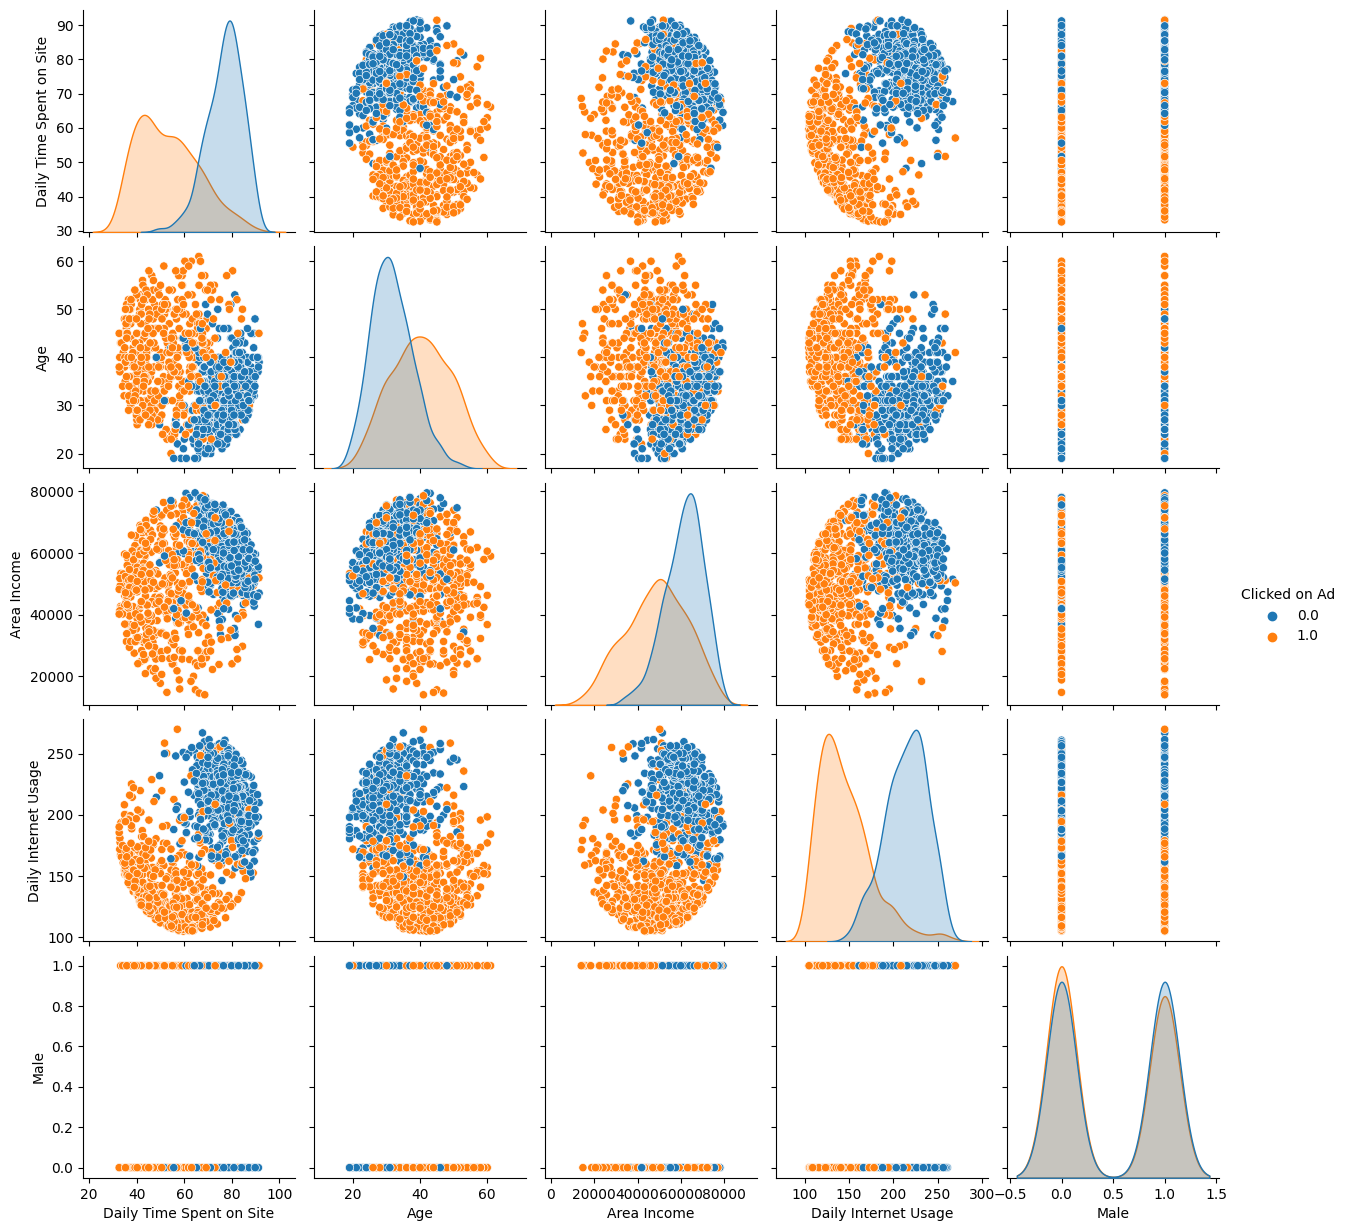

In [29]:
plt.figure()
sns.pairplot(data=advertising[num_vars],
             hue="Clicked on Ad",
             dropna=True)


In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/abhi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 3.3 Feature Engineering

### 3.3.1 Removing Some Features

For the time being, we will remove some features that would need a special approach like time-related analysis to keep our model simple. Furthermore, we will not be considering the "City" feature because of its lack of specificity as stated earlier.

### 3.3.2 Add some features

Now let us take alook at the topic line. There might be some keywords which might make people click and at the same time some keywords which might make them averse. So, let's check the top 10 words in both the cases of click and no-click.

In [31]:
# Get a set of words which do not contribute like articles and prepositions and remove them.
cachedStopWords = stopwords.words("english")

# Get all the remaining words in the succesful click cases.
result  = [word for word in advertising[click_yes]['Ad Topic Line']]
yes_words = ' '.join(result)

# Get all the remaining words in the unsuccesful click cases.
result  = [word for word in advertising[click_no]['Ad Topic Line']]
no_words = ' '.join(result)

pygame 2.1.2 (SDL 2.0.20, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


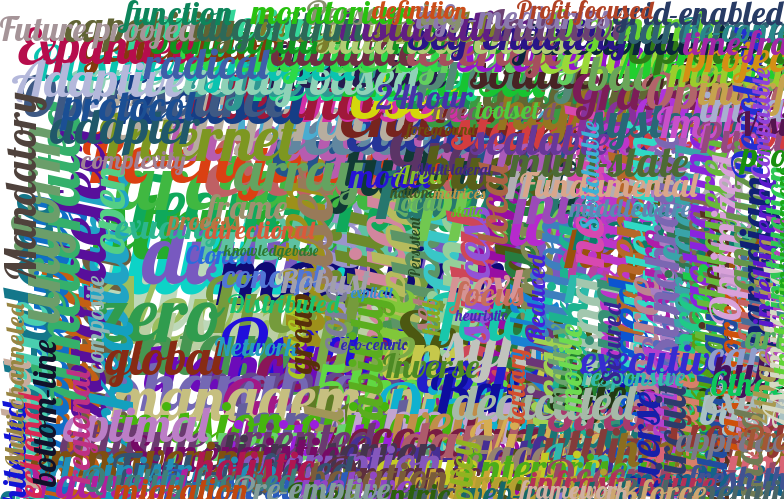

In [32]:
# # Word clous for the case where user clicked
# yes_cloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, stopwords=cachedStopWords).generate(yes_words)

# plt.figure(figsize=(10, 7))
# plt.imshow(yes_cloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()
from collections import Counter
import pytagcloud

# Assuming you have the 'yes_words' variable containing the text
yes_words = " ".join(advertising[advertising['Clicked on Ad'] == 1]['Ad Topic Line'])

# Tokenize the words and count their occurrences
word_counts = Counter(yes_words.split())

# Generate the word cloud
wordcloud = pytagcloud.make_tags(word_counts.items(), maxsize=110)

# Create a text file containing the word cloud data
with open('yes_cloud.txt', 'w') as f:
    for word in word_counts:
        f.write(f"{word}: {word_counts[word]}\n")

# Create the word cloud image
pytagcloud.create_tag_image(wordcloud, 'yes_cloud.png', size=(800, 500), fontname='Lobster')

# Display the word cloud
from IPython.display import Image
Image(filename='yes_cloud.png')


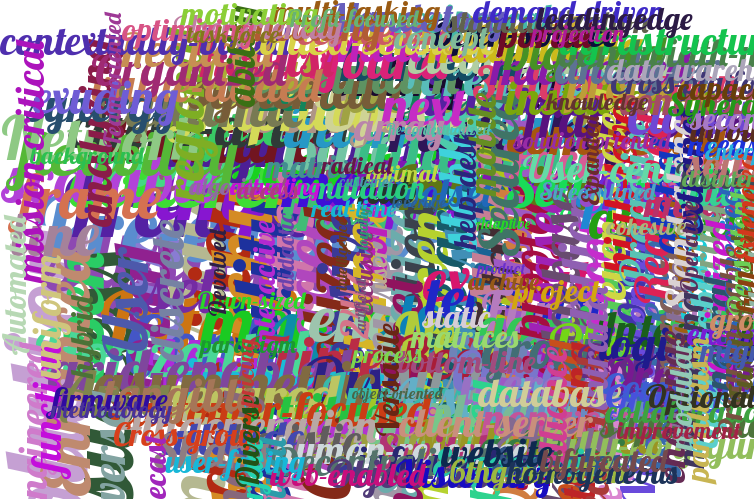

In [33]:
# Assuming you have the 'no_words' variable containing the text for the "no" cloud
no_words = " ".join(advertising[advertising['Clicked on Ad'] == 0]['Ad Topic Line'])

# Tokenize the words and count their occurrences
word_counts = Counter(no_words.split())

# Generate the word cloud
wordcloud = pytagcloud.make_tags(word_counts.items(), maxsize=110)

# Create a text file containing the word cloud data
with open('no_cloud.txt', 'w') as f:
    for word in word_counts:
        f.write(f"{word}: {word_counts[word]}\n")

# Create the word cloud image
pytagcloud.create_tag_image(wordcloud, 'no_cloud.png', size=(800, 500), fontname='Lobster')

# Display the word cloud
from IPython.display import Image
Image(filename='no_cloud.png')


In [34]:
from itertools import islice
# Get a list of top 10 make or break words for "no" cloud
with open('no_cloud.txt', 'r') as f:
    most_used_no = set(islice(f, 10))



In [36]:
# Get a list of top 10 make or break words for "yes" cloud
with open('yes.txt', 'r') as f:
    most_used_yes = set(islice(f, 10))

In [37]:
# user attracting words
most_used_yes

{'Centralized: 5\n',
 'Grass-roots: 5\n',
 'Reactive: 6\n',
 'challenge: 5\n',
 'content-based: 5\n',
 'focus: 3\n',
 'group: 3\n',
 'local: 4\n',
 'neural-net: 6\n',
 'neutral: 6\n'}

In [38]:
# user averse words
most_used_no

{'5thgeneration: 9\n',
 'Cloned: 5\n',
 'Monitored: 9\n',
 'Organic: 5\n',
 'Triple-buffered: 7\n',
 'bottom-line: 3\n',
 'national: 6\n',
 'orchestration: 6\n',
 'service-desk: 7\n',
 'standardization: 3\n'}

In [39]:
# Make sure that these words are not just here because they are most used.
# The common words being empty means that these words might indeed have some influence on the user.
most_used_yes&most_used_no

set()

In [40]:
# Get the total length of the topics which contain both yes_words and no_words.
# High number of this might mean that our theory is wrong or questionable.
def get_contain(x, word_list: list):
    return any([keyword.casefold() in x for keyword in word_list])

In [41]:
# Get rows containing yes_words, no_words and check the total rows containing both of these words.
yes_words_rows = advertising['Ad Topic Line'].apply(lambda x: get_contain(x, most_used_yes))
no_words_rows = advertising['Ad Topic Line'].apply(lambda x: get_contain(x, most_used_no))
(yes_words_rows & no_words_rows).sum()

0

7 rows is actually not very high number out of 200 odd rows containing these words. We will now make a column 'influential_words' which consists of three levels 1,-1 and 0 corresponding to the topic line containing yes_words, no_words and neither of them.

In [42]:
def get_influential_words(x, yes_words:list, no_words:list):
    if any([keyword.casefold() in x for keyword in yes_words]):
        return 1
    elif any([keyword.casefold() in x for keyword in no_words]):
        return -1
    return 0

advertising['influential_words'] = advertising['Ad Topic Line'].apply(lambda x: get_influential_words(x, most_used_yes, most_used_no))

# Now we can drop the 'Ad line' feature as we did manage to manufacture a feature out of it.
advertising = advertising.drop(["Ad Topic Line"], axis=1)

In [43]:
advertising.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,City,Male,Country,Timestamp,Clicked on Ad,influential_words
0,68.95,35,61833.90,256.09,Wrightburgh,0,Tunisia,2016-03-27 00:53:00,0.0,0
1,80.23,31,68441.85,193.77,West Jodi,1,Nauru,2016-04-04 01:39:00,0.0,0
2,69.47,26,59785.94,236.50,Davidton,0,San Marino,2016-03-13 20:35:00,0.0,0
3,74.15,29,54806.18,245.89,West Terrifurt,1,Italy,2016-01-10 02:31:00,0.0,0
4,68.37,35,73889.99,225.58,South Manuel,0,Iceland,2016-06-03 03:36:00,0.0,0


### 3.3.3 Skewed Features: Transform

From our previous EDA, we observe that "Age" was right skewed and "Area Income" was left skewed. We might have to transform them if we need models which assume normal distribution of the features. But since we will be using logistic regression, which does not make this assumption. We will leave it as it is.

### 3.3.4 Normalization Of Numerical Features

In [44]:
# Select the variables that might need to be scaled.
numerical_vars = ["Daily Time Spent on Site", "Area Income", "Daily Internet Usage", "Age"]


# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() 

# Applying the MinMax transformation on the numerical variables
advertising[numerical_vars] = scaler.fit_transform(advertising[numerical_vars])

# Visual check if the scaling is done well or not
advertising.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,City,Male,Country,Timestamp,Clicked on Ad,influential_words
0,0.617882,0.380952,0.730472,0.916031,Wrightburgh,0,Tunisia,2016-03-27 00:53:00,0.0,0
1,0.809621,0.285714,0.831375,0.538746,West Jodi,1,Nauru,2016-04-04 01:39:00,0.0,0
2,0.626721,0.166667,0.699200,0.797433,Davidton,0,San Marino,2016-03-13 20:35:00,0.0,0
3,0.706272,0.238095,0.623160,0.854280,West Terrifurt,1,Italy,2016-01-10 02:31:00,0.0,0
4,0.608023,0.380952,0.914568,0.731323,South Manuel,0,Iceland,2016-06-03 03:36:00,0.0,0


### 3.3.5 Processing Categorical Feature: One Hot-Encoding

In [52]:
# Now look at the remaining set of data and the features type
# Assuming your DataFrame is named df
advertising.drop(columns=['Timestamp'], inplace=True)

advertising.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 1017
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   float64
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   City                      1000 non-null   object 
 5   Male                      1000 non-null   int64  
 6   Country                   1000 non-null   object 
 7   Clicked on Ad             1000 non-null   float64
 8   influential_words         1000 non-null   int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 78.1+ KB


The feature 'Country' is of object type and we may need to create dummies for it.

In [53]:
# Since it is the only column with object type, we can apply get dummies on the entire dataset.
model_data = pd.get_dummies(advertising)

----------

# 4. Model Selection

We will evaluate the model using two metrics:

    - F1-Score
    
    - Accuracy
    

## 4.1 Data Preparation: Training and Testing Sets

In [54]:
# Creating training and test set 
train_data, test_data = train_test_split(model_data, test_size=0.2, random_state=0)

train_data_x = train_data.drop([target], axis=1)
train_data_y = train_data[target]

test_data_x = test_data.drop([target], axis=1)
test_data_y = test_data[target]

## 4.2 Model Selection: Logistic Regression


### 4.2.1 Logistic Regression

First, we will perform a general gridsearch on the penalizing parameter of the L2-Regularization. We will use this search as a guideline for a more focus search in the next step.

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming you have already imported and preprocessed your data
# train_data_x and train_data_y

# Ensure train_data_x is in the correct format (numpy array)
train_data_x = np.array(train_data_x)

# Ensure train_data_y is in the correct format (numpy array)
train_data_y = np.array(train_data_y)

parameters = {"C": [0.01, 0.5, 1, 5, 10]}

model = LogisticRegression(random_state=0, penalty="l2", solver='lbfgs')

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer, cv=5)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(train_data_x, train_data_y)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
# Assuming you have test_data_x and test_data_y
best_predictions = best_clf.predict(test_data_x)

# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(test_data_y, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(test_data_y, best_predictions, beta = 0.5)))
print(best_clf)



Optimized Model
------
Final accuracy score on the testing data: 0.9800
Final F-score on the testing data: 0.9913
LogisticRegression(C=0.01, random_state=0)


/home/abhi/.local/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


The previous step highlighted a value of 0.5 for the C parameter used in the L2-Regularization. We will now perform another search with a much narrower search in order to identify the best parameter.

In [59]:
from sklearn.linear_model import LogisticRegression


parameters = {"C": [0.25, 0.5, 0.75]}

model = LogisticRegression(random_state=42, penalty="l2", solver='lbfgs')

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer, cv=5)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(train_data_x, train_data_y)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(test_data_x)

# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(test_data_y, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(test_data_y, best_predictions, beta = 0.5)))
print(best_clf)


Optimized Model
------
Final accuracy score on the testing data: 0.9800
Final F-score on the testing data: 0.9913
LogisticRegression(C=0.5, random_state=42)


/home/abhi/.local/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [62]:
import pickle

# Save the trained model to disk
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_clf, f)

# Save model configuration and hyperparameters
model_info = {
    'random_state': best_clf.random_state,
    'penalty': best_clf.penalty,
    'solver': best_clf.solver,
    'best_params': grid_fit.best_params_
}
with open('model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)




From the logisitic regression, with a model including most of our features, our best result on the training set are:

   **1. Accuracy of 98%**

   **2. F-score of 99.13%**
    
with L2-Regularization with C=0.5

Let's look at other metrics such as the precision and recall

### 4.2.2 Confusion Matrix, Precision, Recall, F1-Score

In [63]:
# Confusion matrix
confmat = confusion_matrix(test_data_y, best_predictions)
print("The Confusion matrix:\n", confmat)
print("Precision Score:", round(precision_score(test_data_y, best_predictions), 2))
print("Recall Score:", round(recall_score(test_data_y, best_predictions), 2))

The Confusion matrix:
 [[105   0]
 [  4  91]]
Precision Score: 1.0
Recall Score: 0.96


Because of our business problem, we want to focus on **lowering the false positive** since they are costing the company money when we spend money on a client that does not click on the ad. It is worth noting that considering the amount of profit the company is making following the campaign and the amount of money that is being made from false negatives, it is definitely worth it NOT to make any campaign and hoping for a maximum number of false negatives.
However, let's say that we can get more insights with our clients by identifying potential features that would support the idea if a client will click on our ad or not. Therefore, we want to have an interpretable model that has a **great precision to minimize the false positive** which incur loss of money, and a model that could have a **lower specificity (e.g., recall) which increases profit anyway**. Actually if it costs 1000USD to target a customer and brings an overall profit of 100USD, then we can estimate that the overall profit from someone clicking on the ad is 1100USD. Therefore, **it is definitely worth it to have false negative**.  

In [64]:
def summary_metrics(y, y_pred):
    confmat = confusion_matrix(y, y_pred)
    TP = confmat[0,0]
    FN = confmat[0,1]
    FP = confmat[1,0]
    TN = confmat[1,1]
 
    # Print the confusion matrix
    print("Confusion matrix:\n", confmat)
    print()
    
    # Print the Accuracy Score
    print("Accuracy:", round(accuracy_score(y, y_pred),2))

    # Print the Sensitivity/recall/true positive rate
    print("Sensitivity:", round(recall_score(y, y_pred),2))

    # Precision/positive predictive value
    print("Precision:", round(precision_score(y, y_pred),2))

    print("")
    print("DETAILS")
    
    # RETURN ON TP
    print("True Positive:", round((float(TP)*100),2))
    
    # Return on FP
    print("False Positive:", round((float(FP) * -1050),2))
    
    # Return on FN
    print("False Negative:", round((float(FN) * 1100),2))
    
    # Return on TN
    print("True Negative:", round((float(TN) * 0), 2))
    
    # Return on investment
    investment_return = (TP * 100) + (FP * -1050) + (FN * 1100) + (TN * 0)
    print("Profit:", round(float(investment_return),2), "$")

In [65]:
# Getting the metrics from the confusion matrix with our best model on our training set
fitted_values = best_clf.predict(train_data_x)
print(summary_metrics(train_data_y, fitted_values))

Confusion matrix:
 [[393   2]
 [ 14 391]]

Accuracy: 0.98
Sensitivity: 0.97
Precision: 0.99

DETAILS
True Positive: 39300.0
False Positive: -14700.0
False Negative: 2200.0
True Negative: 0.0
Profit: 26800.0 $
None


As mentioned previously, let's look at the probability distribution of our model to see if increasing the threshold could be beneficial to reduce the number of false positive, consequently reducing our loss.

Text(0, 0.5, 'Frequency')

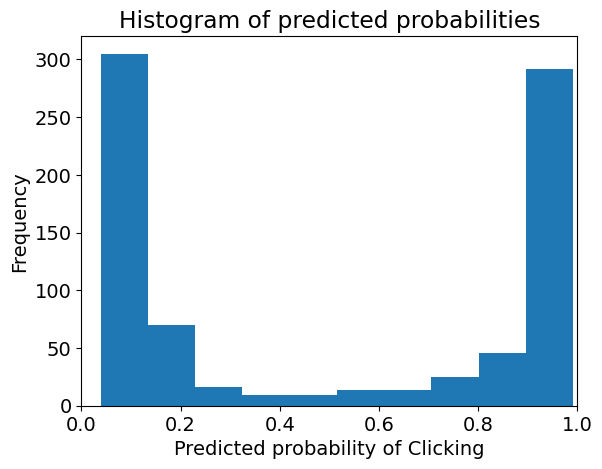

In [66]:
train_pred_prob = best_clf.predict_proba(train_data_x)[:,1]

plt.rcParams["font.size"]= 14
plt.hist(train_pred_prob, bins=10)
plt.xlim(0, 1)
plt.title("Histogram of predicted probabilities")
plt.xlabel("Predicted probability of Clicking")
plt.ylabel("Frequency")

It looks like our model does not carry a lot of ambiguity when it comes down to predicting if someone will click on the ad or not. We could still raise our threshold to 0.6 to decrease the chance of a false positive, even though our current model seems quite categorical.

In [67]:
train_pred_class = np.where(train_pred_prob<0.4,0,1)
summary_metrics(train_data_y, train_pred_class)

Confusion matrix:
 [[389   6]
 [  8 397]]

Accuracy: 0.98
Sensitivity: 0.98
Precision: 0.99

DETAILS
True Positive: 38900.0
False Positive: -8400.0
False Negative: 6600.0
True Negative: 0.0
Profit: 37100.0 $


By decreasing the threshold from 0.5 to 0.4, we helped reducing the number of false positives (e.g., 1), which result in a benefit. However, it is important to highlight that decreasing the threshold, even if it helps reducing the amount of false positives, the prediction of still having false negative customers clicking on the ad is to be closely monitored. 

Let's look at our test set to see how we would perform with this model

In [68]:
test_predictions = best_clf.predict(test_data_x)
summary_metrics(test_data_y, test_predictions)


Confusion matrix:
 [[105   0]
 [  4  91]]

Accuracy: 0.98
Sensitivity: 0.96
Precision: 1.0

DETAILS
True Positive: 10500.0
False Positive: -4200.0
False Negative: 0.0
True Negative: 0.0
Profit: 6300.0 $


/home/abhi/.local/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [69]:
test_pred_prob = best_clf.predict_proba(test_data_x)[:,1]
test_pred_click = np.where(test_pred_prob<0.45, 0, 1)

/home/abhi/.local/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [70]:
summary_metrics(test_data_y, test_pred_click)

Confusion matrix:
 [[104   1]
 [  4  91]]

Accuracy: 0.98
Sensitivity: 0.96
Precision: 0.99

DETAILS
True Positive: 10400.0
False Positive: -4200.0
False Negative: 1100.0
True Negative: 0.0
Profit: 7300.0 $


Considering out test set which included a sample size of 200 customers, we predict that our **overall profit would be 7300usd**. This prediction includes 
- **Profit of 10400usd from true positives**
- **Profit of 1100usd from false negatives**
- **Loss of 4200usd from false positives**

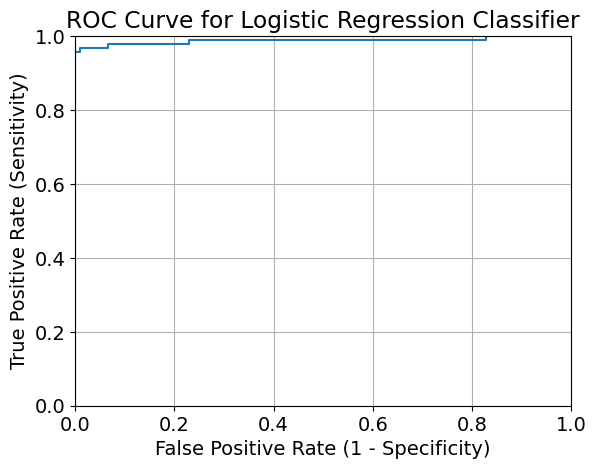

In [71]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_data_y, test_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("ROC Curve for Logistic Regression Classifier")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.grid(True)

Daily Time Spent on Site    2.472276e-01
Age                         9.810259e-02
Area Income                 9.413974e-02
Daily Internet Usage        2.731757e-01
Male                        5.122083e-03
influential_words           0.000000e+00
City_Adamsbury              3.380470e-05
City_Adamside               4.437657e-04
City_Adamsstad              5.006035e-05
City_Alanview               1.492210e-04
City_Alexanderfurt          1.887682e-08
City_Alexanderview          8.665438e-05
City_Alexandrafort          6.060625e-05
City_Alexisland             9.616068e-06
City_Aliciatown             5.716371e-04
dtype: float64


<Axes: >

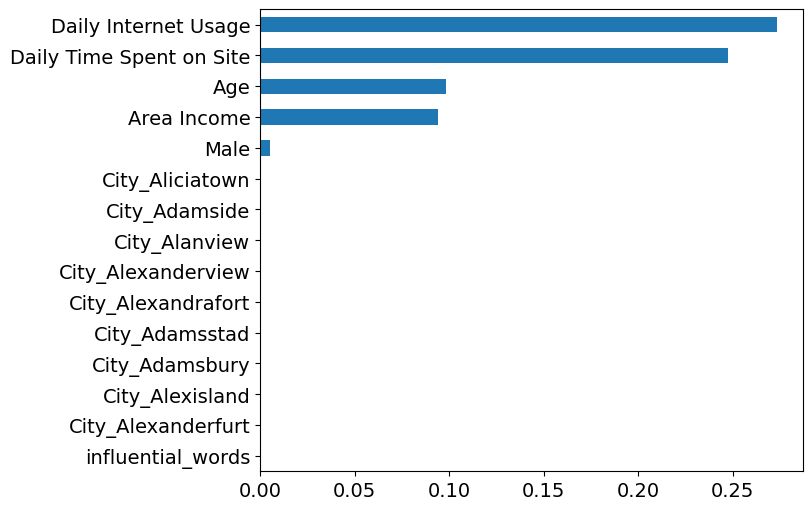

In [72]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(train_data_x, train_data_y)

# Extracting feature importances from our model
feature_importances = pd.Series(model_rf.feature_importances_, index=model_data.drop([target],axis=1).columns)
sub_feature_importances = feature_importances[:15]
print(sub_feature_importances)

sub_feature_importances.sort_values(inplace=True)
sub_feature_importances.plot(kind='barh', figsize=(7,6))

## 5. Actionable Recommendations
According to our model, the most useful features to identify potential clients are:

- Daily Time Spent on site
- Daily Internet Usage
- Age
- Area income

We need to target the audience based on these features as well as try to use influential words to attract more people to click. 
From our exploratory data analysis and our machine learning results, our ***targeted population*** would be customers with:

- **Lower income**
- **Spending less time on the website**
- **Spending less time on the internet**
- **Who are older than our average sample (around 40 years old)**
